In [1]:
using Distributions, Turing, StatsPlots, StatsBase, Random, RDatasets, CSV, DataFrames

# Assignment 2: hierarchical models

Students|
-------|

Name        |       Id
------------|----------
Ploni Almoni|123489589
John Smith  |923352302

## Summary

In this assignment we explore hierarchical models for analysis of data consisting of multiple related groups. The assignment is based on the [class material](https://bgu-abda.bitbucket.io/#lectures): 

5. Hierarchical models
6. Hierarchical models, cont.

The assignment consists of two problems. Solve the problems in either Jupyter or Pluto notebook.
In addition to computations, solutions must include **graphical visualization** and **numerical characterization** of the posterior.

## Problem 1: warp breaks

Julia provides to [R datasets](https://www.rdocumentation.org/packages/datasets/versions/3.6.2) via package RDatasets. We will use the [warpbreaks](https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/warpbreaks) dataset for this problem. You can load the dataset into data frame `df` as follows:

In [2]:
df = RDatasets.dataset("datasets", "warpbreaks");

Infer the probability distribution of warp breaks for each of two wool types. Compare the results under separate and hierarchical models. Conduct two studies:

1. Ignore warp tension and compare wool types based on all experiments. 
2. Account for warp tension in both the hierarchical model and the separate model.

## Problem 2. City of Norfolk employee salaries

City of Norfolk provides access to [employee salary data](https://data.norfolk.gov/Government/Employee-Salaries/4fsk-z8s8). Analyze the salary distributions 

1. by department;
2. by department and employee status.

Compare the analysis under separate and hierarchical models. A small number of groups are very different from the rest, how do you propose to handle the difference in the hierarchical model?

In [3]:
fpath = raw"C:\Users\noam\Repositories\bgu-abda.bitbucket.io\homework\02norfolk_employee_data.csv";

In [4]:
df = CSV.read(fpath, DataFrame);
first(df, 5)

,Department,Position Title,Employee Status,Initial Hire Date
,String,String,String,String
1,CF - MacArthur Memorial,Museum Attendant,Casual Part-time,06/04/2007
2,CF - MacArthur Memorial,Museum Attendant,Casual Part-time,11/13/2006
3,CF - MacArthur Memorial,Museum Attendant,Permanent Full-time,09/23/2020
4,CF - MacArthur Memorial,Museum Attendant,Permanent Full-time,01/07/2019
5,CF - MacArthur Memorial,Administrative Technician,Permanent Full-time,09/23/2015


### Exploratory Data Analysis

First, we will explore the dataset.

In [5]:
size(df) # (num_rows, num_columns)

(4399, 7)

In [6]:
names(df) # names of columns

7-element Vector{String}:
 "Department  "
 "Position Title"
 "Employee Status"
 "Initial Hire Date"
 "Date in Position"
 "Fair Labor Standards Act (FLSA) "
 "Base Salary"

Thus, the original dataset includes 4399 employees and 7 fields of information.

Let's trim the whitespaces surrounding "Department  " and filter unnecessary columns.

In [7]:
try # Running this block a second time throws an ArgumentError
    rename!(df, "Department  " => "Department");
catch
    ArgumentError
end

df = df[:, ["Department", "Employee Status", "Base Salary"]]
names(df)

3-element Vector{String}:
 "Department"
 "Employee Status"
 "Base Salary"

### Exploring Base Salary

Let us plot a histogram of the base salary.

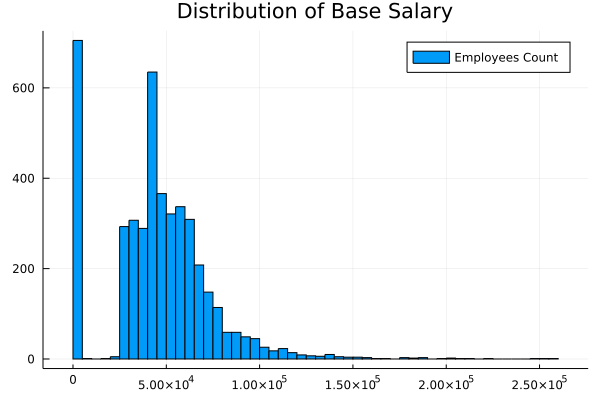

In [12]:
histogram(df."Base Salary", title="Distribution of Base Salary", label="Employees Count")

<b>Observation</b>: The salary distribution is **clustered**: employees either have salaries in the range (9,150) or in (3500, 260000).

**Explanation**: The base salaries reflect either an hourly rate or a monthly income.

**Action**: In order to correct for the different values in this column, we will decide that any value under 1000 is an hourly rate and any value at or above 1000 is a monthly salary. We will summarize this in a new column "Monthly Salary".

This is the histogram of the new column:

In [57]:
df = transform(df, :"Base Salary" => ByRow(x -> x < 1000 ? 40 * 4 * x : x) => :"Monthly Salary");

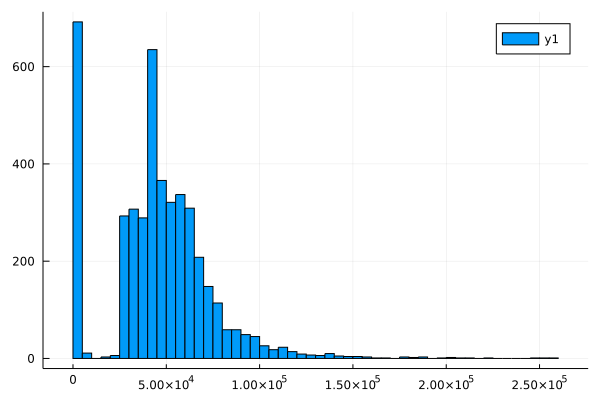

In [58]:
histogram(df[!,"Monthly Salary"])

In [70]:
departments_df = combine(groupby(df, [:Department]), df -> 
        DataFrame(
            mean_monthly_salary = mean(df[!,"Monthly Salary"]),
            count_employees = nrow(df),
            std_monthly_salary = std(df[!,"Monthly Salary"])
        ))

,Department,mean_monthly_salary,count_employees,std_monthly_salary
,String,Float64,Int64,Float64
1,CF - MacArthur Memorial,33287.9,8,24009.5
2,CF-Cultural&Convention Center,2120.0,2,303.207
3,CFAE-Cultural Affrs/SpecEvents,38083.7,1,NaN
4,Cemetery Fund,37754.7,21,17433.0
5,Circuit Court Judges,63708.2,10,15387.9
6,City Assessor,57941.6,25,25665.3
7,City Auditor,77534.2,9,20088.8
8,City Clerk,70428.0,10,28776.1
9,City Council,25285.7,7,755.924


In [67]:
combine(groupby(df, [:Department]), df -> std(df[!,"Monthly Salary"]))

,Department,x1
,String,Float64
1,CF - MacArthur Memorial,24009.5
2,CF-Cultural&Convention Center,303.207
3,CFAE-Cultural Affrs/SpecEvents,NaN
4,Cemetery Fund,17433.0
5,Circuit Court Judges,15387.9
6,City Assessor,25665.3
7,City Auditor,20088.8
8,City Clerk,28776.1
9,City Council,755.924


### Exploring Department

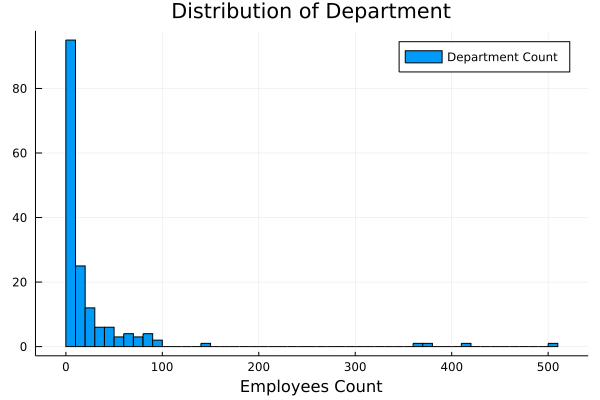

In [9]:
histogram(departments_count.count, title="Distribution of Department", xlabel="Employees Count", label="Department Count")

<b>Observation</b>: There are 165 departments total. The top 5 largest departments consist of ~40% of the employees. The remaining 160 departments hold the other ~60%.

### Exploring Employee Status

<b>Observation</b>: The are 17 employement statuses total. 14 statuses have little employee counts (166) and 3 statuses have the lion's share (remaining 4170)